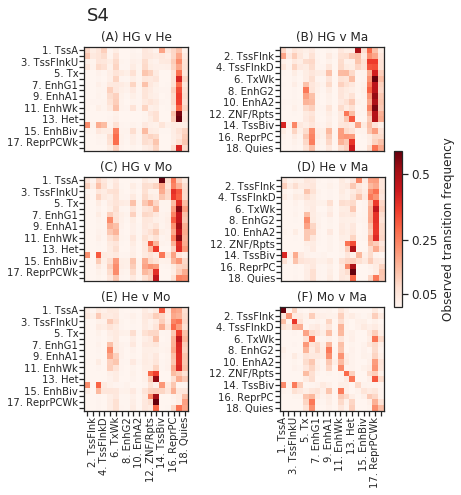

In [3]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti
import json as js
import string as string

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot CMM18 state transitions
# as heatmaps (supp. material)

date = '20190804'

run_plot_state_transitions = True
save_figures = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')
input_dir = os.path.join(fhgfs_base, 'sciddo', 'deep')

journal = 'bmc_genbio'
res = 'print_hi'
fig_sizes = js.load(open('/home/pebert/work/code/github/project-diff-chromatin-state/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['emission', 'replicate']
segmentations = ['cmm18', 'ecs18', 'ecs10']
cmm_state_emissions = '/home/pebert/work/code/github/project-diff-chromatin-state/annotation/chromhmm_18/emissions_18_core_K27ac.txt'

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

base_out = '/TL/epigenetics2/work/pebert/cloud/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')


def to_rgb(color):
    r, g, b = color.split(',')
    r = int(r) / 255
    g = int(g) / 255
    b = int(b) / 255
    return r,g,b


def plot_transition_panel(count_files, fkey):
    
    comparisons = sorted(count_files.keys())
    assert len(comparisons) == 6, '.....'
        
    ncols = 2
    nrows = 3
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=nrows, ncols=ncols,
                             sharex=False, sharey=False)
    
    plt.subplots_adjust(hspace=0.25, wspace=0.1)
    
    sub_panel = {i: c for i, c in zip(range(len(comparisons)), string.ascii_uppercase)}
    
    comp_idx = 0
    cbar = None
    tt = None
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row, col]
                        
            comp = comparisons[comp_idx]
            panel = sub_panel[comp_idx]
            comp_idx += 1
            
            count_file = count_files[comp]
            count_data = pd.read_csv(count_file, sep='\t', header=0, index_col=0)
            trans_freq = count_data.divide(count_data.sum(axis=1), axis=0)
            assert np.allclose(trans_freq.sum(axis=1), 1, atol=1e-9), 'division axis mismatch'
            
            img = ax.imshow(trans_freq.values, cmap='Reds')
            
            label = ' v '.join(comp.split('_vs_'))
            ax_tt = ax.set_title('({}) {}'.format(panel, label), fontsize=12)
                 
            
            if col == 0:
                ax.set_yticks(np.arange(0, 18, 1))
                ax.set_yticklabels([' ' if p % 2 == 0 else str(p) + '. ' + l for p, l in enumerate(count_data.index, 1)], fontsize=10)
                ax.tick_params(left=True, axis='y', which='major', pad=1, length=5, direction='out')
            elif col == 1:
                ax.set_yticks(np.arange(0, 18, 1))
                ax.set_yticklabels([' ' if p % 2 != 0 else str(p) + '. ' + l for p, l in enumerate(count_data.index, 1)], fontsize=10)
                ax.tick_params(left=True, axis='y', which='major', pad=1, length=5, direction='out')
            else:
                ax.set_yticks([])

            if row == 0 and col == 0:
                tt = ax.text(0.025, 1.25, fkey, fontsize=18, transform=ax.transAxes)
                    
            if row == 1 and col == 1:
                cbar = plt.colorbar(img, ax=ax, shrink=1.5)
                cbar.set_label('Observed transition frequency', fontsize=12)
                cbar.set_ticks([0.05, 0.25, 0.5])
                cbar.ax.set_yticklabels(['0.05', '0.25', '0.5'], fontsize=12)

            if col == 0 and row == 2:
                ax.set_xticks(np.arange(0, 18, 1))
                ax.set_xticklabels([' ' if p % 2 != 0 else str(p) + '. ' + l for p,l in enumerate(count_data.index, 1)],
                                   fontsize=10, rotation=90)
                ax.tick_params(bottom=True, axis='x', which='major', pad=1, length=5, direction='out')
            elif col == 1 and row == 2:
                ax.set_xticks(np.arange(0, 18, 1))
                ax.set_xticklabels([' ' if p % 2 == 0 else str(p) + '. ' + l for p,l in enumerate(count_data.index, 1)],
                                   fontsize=10, rotation=90)
                ax.tick_params(bottom=True, axis='x', which='major', pad=1, length=5, direction='out')
            else:
                ax.set_xticks([])
                        
    return fig, [tt, cbar]


def plot_hsp_state_transitions():

    use_segmentation = ['cmm18']
    use_scoring = ['penem']
    fkey = 'S4'
    
    for seg in use_segmentation:
        for score in use_scoring:
            count_files = dict()
            for root, dirs, files in os.walk(input_dir):
                if not root.endswith('transition_counts'):
                    continue
                for f in files:
                    if seg not in f or score not in f:
                        continue
                    if 'Liver_vs_Blood' in f:
                        continue
                    key = '_'.join(f.split('_')[2:5])
                    count_files[key] = os.path.join(root, f)
        
            fig, exart = plot_transition_panel(count_files, fkey)
            if save_figures:
                outname = 'fig_{}_state_transitions_{}_{}'.format(fkey, seg, score)
                outfolder = fig_supp

                out_png = os.path.join(outfolder, outname + '.png')
                fig.savefig(out_png, bbox_inches='tight', transparent=True,
                            extra_artists=exart, dpi=resolution[res])

                out_pdf = os.path.join(outfolder, outname + '.pdf')
                fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)

    return 0

if run_plot_state_transitions:
    plot_hsp_state_transitions()